In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from quant_free.dataset.us_equity_load import *
from quant_free.utils.us_equity_utils import *
from quant_free.factor.price import *


from quant_free.finml.utils.multiprocess import mp_pandas_obj

symbol = 'TSM'
symbol = 'AAPL'
# symbol = 'INTC'

factor_name = 'Trend.csv'
like = 'trend'

# factor_name = 'Alpha101.csv'
# like = 'alpha'

thr = 0.00
forward_period = 10
start_date = get_json_config_value("training_start_date")
end_date = get_json_config_value("training_end_date")

factor = us_equity_data_load_within_range(symbols = [symbol], start_date = start_date,
                                end_date = end_date, column_option = "all", file_name = factor_name)[symbol]
factor = factor.replace({True: 1, False: 0})
factor = factor.loc[:, (factor != 0).any(axis=0)]
# trnsX = factor.loc[:, ['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha6', 'alpha7', 'alpha8', 'alpha9', 'alpha10', 'alpha11', 'alpha12', 'alpha13', 'alpha14', 'alpha15']]
trnsX = factor.filter(like=like).astype(np.float64)
# print(trnsX.head(5))


# price_ratio = PriceRatio(start_date, end_date, symbol = symbol, column_option = 'close', dir_option = 'xq')
# y_data = price_ratio.price_ratio(periods = periods)
y_data = factor.loc[:, f'ret_forward_{forward_period}']
cont = pd.DataFrame(y_data.map(lambda x: 1 if x > thr else 0 if x < -thr else 0))
cont = pd.concat([cont, y_data], axis = 1)
cont.columns = ['bin', f'price_ratio_{forward_period}']
cont['t1'] = cont.index

print(cont.tail(10))


            bin  price_ratio_10         t1
2020-09-23    1        0.071678 2020-09-23
2020-09-24    1        0.060505 2020-09-24
2020-09-25    1        0.040921 2020-09-25
2020-09-28    1        0.079079 2020-09-28
2020-09-29    1        0.059629 2020-09-29
2020-09-30    1        0.045409 2020-09-30
2020-10-01    1        0.033014 2020-10-01
2020-10-02    1        0.051727 2020-10-02
2020-10-05    0       -0.004473 2020-10-05
2020-10-06    1        0.037720 2020-10-06


In [16]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 100,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

# fit = forest.fit(X = trnsX, y = cont['bin'])
# oob_score = fit.oob_score_
# print(f"oob_score {oob_score}")

from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score
from quant_free.finml.feature_importance.importance import *
cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

def compute_feature_importance(clf, X, y, cv_gen, molecule):
    scoring = log_loss
    sample_weight = None
    
    factor_ = X.loc[:, molecule]
    sfi = single_feature_importance(
        clf, # base classification model
        factor_, # train features
        cont['bin'], # train labels
        cv_gen, # purged k fold cross validation class
        scoring = accuracy_score
    )
    
    return sfi

In [17]:
def single_feature_importance_parallel(clf, X, y, cv_gen, scoring = log_loss, sample_weight = None):
    feature_names = X.columns
    if sample_weight is None:
        sample_weight = np.ones((X.shape[0],))

    num_threads=8
    imp = mp_pandas_obj(
                        func = compute_feature_importance,
                        pd_obj = ('molecule', feature_names),
                        num_threads =num_threads,
                        clf = clf,
                        X = X,
                        y = y,
                        cv_gen = cv_gen
                        )
    # imp = imp.set_index('index')
    return imp

sfi = single_feature_importance_parallel(
    forest, # base classification model
    factor, # train features
    cont, # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

100%|██████████| 12/12 [07:43<00:00, 38.61s/it]e_importance done after 7.42 minutes. Remaining 1.06 minutes.
2025-02-15 07:19:22.038099 100.0% compute_feature_importance done after 7.73 minutes. Remaining 0.0 minutes.


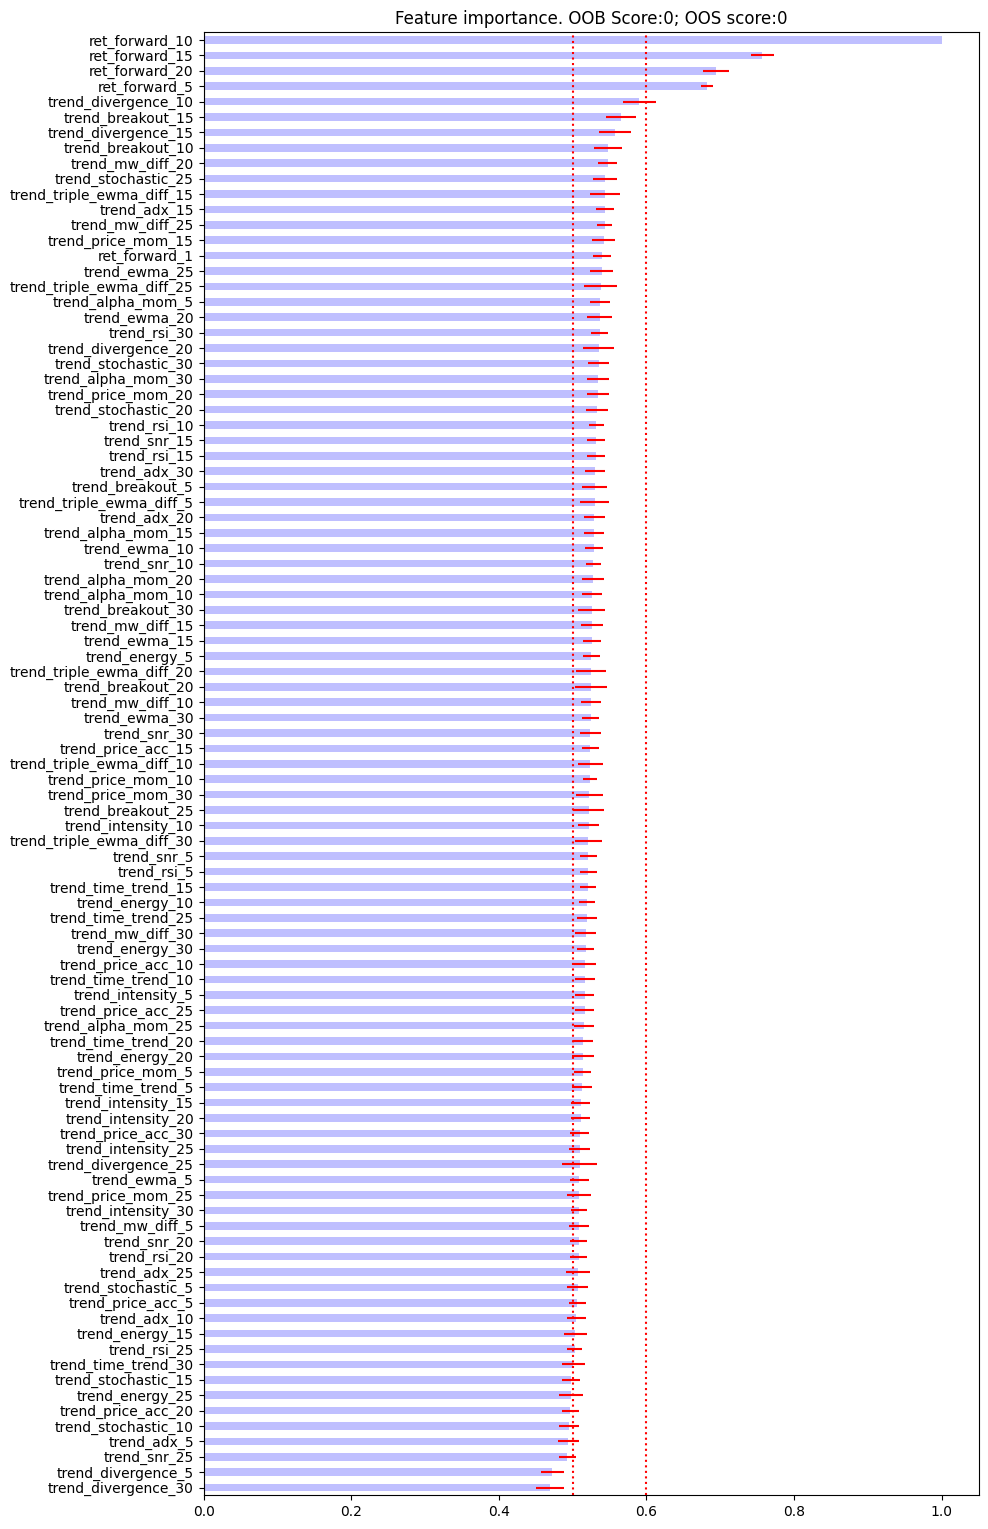

In [18]:
plot_feature_importance(
    sfi,
    oob_score = 0,
    oos_score = 0,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like}_SFI_feature_importance.png'
)
plt.axvline(0.5, ls = ':', color = 'r')
plt.axvline(0.6, ls = ':', color = 'r')
plt.grid(False)
plt.show()